Conjuntos de dados e carregadores de dados
======================


O código para processar amostras de dados pode ser confuso e difícil de manter; 
o ideal é que o código do nosso conjunto de dados seja desacoplado do código de treinamento 
do modelo para melhor legibilidade e modularidade. 
O PyTorch fornece duas primitivas de dados: `torch.utils.data.DataLoader` e `torch.utils.data.Dataset`
que permitem usar conjuntos de dados pré-carregados, bem como seus próprios dados.
O `Dataset` armazena as amostras e seus rótulos correspondentes, E
`DataLoader` envolve um iterável em torno do `Dataset` para facilitar o acesso às amostras.

As bibliotecas de domínio do PyTorch fornecem diversos conjuntos de dados 
pré-carregados (como FashionMNIST) que subclassificam `torch.utils.data.Dataset` e implementam funções específicas para os dados em questão. Elas podem ser usadas para prototipar e comparar seu modelo. Você pode encontrá-las aqui: 
[ImageDatasets](https://pytorch.org/vision/stable/datasets.html), 
[TextDatasets](https://pytorch.org/text/stable/datasets.html), and 
[AudioDatasets](https://pytorch.org/audio/stable/datasets.html)


Carregando um conjunto de dados
=================

Aqui está um exemplo de como carregar o conjunto de dados
[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)
do TorchVision. Fashion-MNIST é um conjunto de dados de imagens de artigos da Zalando, 
composto por 60.000 exemplos de treinamento e 10.000 exemplos de teste. 
Cada exemplo compreende uma imagem em tons de cinza de 28×28 e um rótulo associado de uma das 10 classes

Carregamos o [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) com os seguintes parâmetros:  

* `root` é o caminho onde os dados do trem/teste são armazenados  
* `train` especifica conjunto de dados de treinamento ou teste
* `download=True` baixa os dados da internet se não estiverem disponíveis em `root`
* `transform` e `target_transform` especificar as transformações de recursos e rótulos


In [10]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Iterando e visualizando o conjunto de dados
=====================================

Podemos indexar `Datasets` manualmente como uma lista: `training_data[index]`.  
Usamos `matplotlib` para visualizar algumas amostras em nossos dados de treinamento.


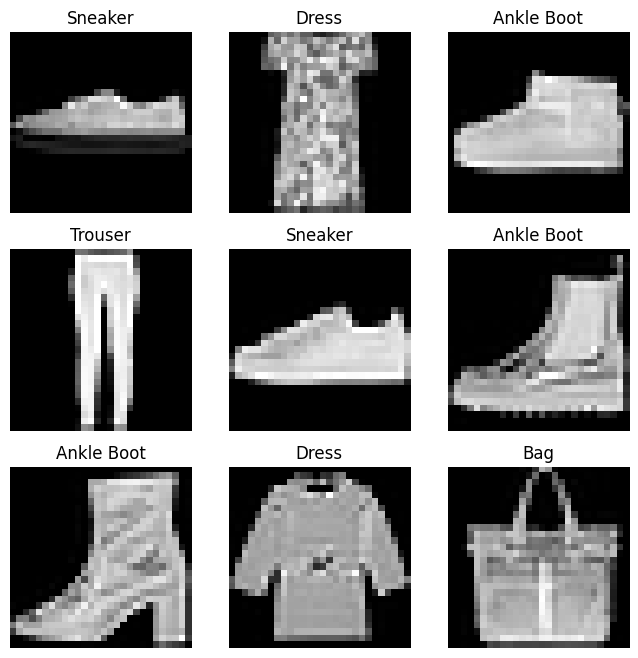

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    #sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample_idx = int(torch.randint(len(training_data), size=(1,)).item())
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

------------------------------------------------------------------------


Criando um conjunto de dados personalizado para seus arquivos
========================================

Uma classe Dataset personalizada deve implementar três funções:
[\_\_init\_\_]{.title-ref}, [\_\_len\_\_]{.title-ref}, e
[\_\_getitem\_\_]{.title-ref}. Veja esta implementação: 
as imagens FashionMNIST são armazenadas em um diretório `img_dir`, 
e seus rótulos são armazenados separadamente em um arquivo CSV `annotations_file`.

Nas próximas seções, detalharemos o que acontece em cada uma dessas funções.

In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]))
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

`__init__`
==========

A função __init__ é executada uma vez ao instanciar o objeto Dataset.  
Inicializamos o diretório que contém as imagens, o arquivo de anotações e ambas as transformações (abordadas com mais detalhes na próxima seção).

O arquivo labels.csv se parece com:

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9


In [13]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

`__len__`
=========

A função __len__ retorna o número de amostras em nosso conjunto de dados.

Exemplo:


In [14]:
def __len__(self):
    return len(self.img_labels)

`__getitem__`
=============

A função __getitem__ carrega e retorna uma amostra do conjunto de dados 
no índice fornecido `idx`. Com base no índice, ela identifica a localização
 da imagem no disco, converte-a em um tensor usando
`decode_image`, recupera o rótulo correspondente dos dados CSV em
`self.img_labels`, chama as funções de transformação neles (se aplicável) e 
retorna a imagem do tensor e o rótulo correspondente em uma tupla.

In [15]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = decode_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

------------------------------------------------------------------------


Preparando seus dados para treinamento com DataLoaders
=================================================

O `Dataset` recupera as características do nosso conjunto de dados e rotula 
uma amostra por vez. Ao treinar um modelo, normalmente queremos passar 
amostras em "minilotes", embaralhar os dados a cada época para reduzir o 
sobreajuste do modelo e usar o Python `multiprocessing` para acelerar a 
recuperação de dados.

`DataLoader` é um iterável que abstrai essa complexidade para nós em uma API fácil.


In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterar pelo DataLoader
==============================

Carregamos esse conjunto de dados em `DataLoader` e podemos iterar pelo 
conjunto de dados conforme necessário. Cada iteração abaixo retorna um lote de 
`train_features` e `train_labels` (contendo `batch_size=64` recursos e rótulos, 
respectivamente). Como especificamos `shuffle=True`, após iterarmos sobre todos 
os lotes, os dados são embaralhados (para um controle mais refinado sobre a 
ordem de carregamento dos dados, consulte
[Amostras](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


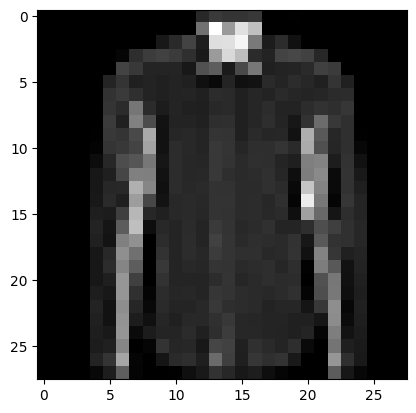

Label: 6


In [17]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

------------------------------------------------------------------------


Leitura adicional
===============

-   [torch.utils.data API](https://pytorch.org/docs/stable/data.html)
